In [152]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : HandCrafted AntiSymmetric Bipolar Convolution


In [153]:
k =  3 # Top 10% highest l2-magnitude filters

In [154]:
t = np.zeros((1,2))
t[0,1] = np.sqrt(0.75)
print(fft.idctn(t, norm="ortho"), (k,k,1,1))
tf.math.reduce_euclidean_norm(fft.idctn(t, norm=None))


[[ 0.61237244 -0.61237244]] (3, 3, 1, 1)


<tf.Tensor: shape=(), dtype=float64, numpy=0.21650635094610965>

In [155]:
t = np.zeros((1,2))
t[0, 0] = np.sqrt(0.25)
print(fft.idctn(t, norm="ortho"), (k,k,1,1))

tf.math.reduce_euclidean_norm(fft.idctn(t, norm=None))


[[0.35355339 0.35355339]] (3, 3, 1, 1)


<tf.Tensor: shape=(), dtype=float64, numpy=0.08838834764831845>

In [156]:
0.61237244/2

0.30618622

In [157]:
F = 0
k = 3
filters = np.zeros((k,k,1,1))

t = np.zeros((k,k))
b2 = 0.75
t[1,0] = np.sqrt(b2)
t[0, 0] = np.sqrt(1-b2)
filters = np.reshape(fft.idctn(t, norm="ortho"), (k,k,1,1))
#filters /= np.sum(filters**2)



#filters[:,:,0,0] =  (1/9)*np.array([[1,1,1], [1,1,1], [1,1,1]]) + (1/6)*np.array([[1,1,1], [0,0,0], [-1,-1,-1]]) 


print(filters.shape)
s, a = getSymAntiSymTF(filters)

a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])
mag = reduce_euclidean_norm(filters, axis=[0,1])


print((a_mag**2)/(mag**2))




(3, 3, 1, 1)
(1, 3, 3, 1) (1, 3, 3, 1) (1, 3, 3, 1)
tf.Tensor([[0.75]], shape=(1, 1), dtype=float64)


In [158]:
filters[:,:,0,0]

array([[ 0.52022006,  0.52022006,  0.52022006],
       [ 0.16666667,  0.16666667,  0.16666667],
       [-0.18688672, -0.18688672, -0.18688672]])

In [159]:
3//2

1

In [160]:
#var = 2/(128*9)

img = np.zeros((355,355)) # cv2.imread('input4.png', 0)/255. 
mid = img.shape[0]//2
img[mid, mid] = 1.
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

(355, 355)


In [161]:
np.var(img), 1/(128*9)


(np.float64(7.9348705817612e-06), 0.0008680555555555555)

(3, 3, 1, 1)
0
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(0.0, shape=(), dtype=float32) 0.0
(1, 355, 355, 1)
1
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(0.75733334, shape=(), dtype=float32) 0.4286952
(1, 355, 355, 1)
2
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(1.6095016, shape=(), dtype=float32) 0.48786208
(1, 355, 355, 1)
3
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(2.5099316, shape=(), dtype=float32) 0.49990135
(1, 355, 355, 1)
4
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(3.4383347, shape=(), dtype=float32) 0.4961828
(1, 355, 355, 1)
5
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(4.3576155, shape=(), dtype=float32) 0.5180103
(1, 355, 355, 1)
6
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(5.254255, shape=(), dtype=float32) 0.56632525
(1, 355, 355, 1)
7
(1, 355, 355, 1)
VALS 0.99999994
tf.Tensor(6.145378, shape=(), dtype=float32) 0.61108947
(1, 355, 355, 1)
8
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(7.0409193, shape=(), dtype=float32) 0.6431975
(1, 355, 355, 1)
9
(1, 355, 355, 1)
VALS 1.0
tf.Tensor(7.9453373, shape=(), dtype=float32) 0.6624

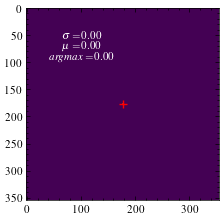

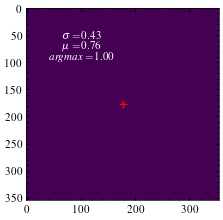

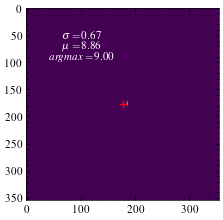

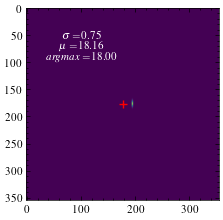

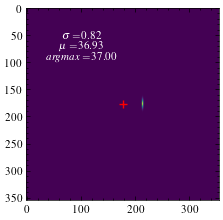

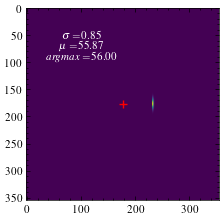

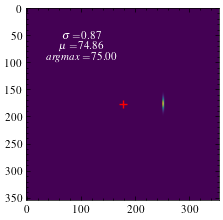

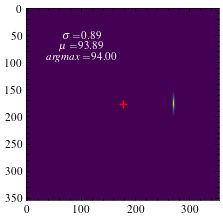

In [162]:
import matplotlib.patches as mpatches

w =tf.cast(filters, dtype=tf.float32)# tf.expand_dims(filters, -1), dtype=tf.float32)
w = tf.transpose(w, perm=(1,0,2,3))
print(w.shape)

x = img
v= []
old_mean = 0
directory = f"figures/prop_unipolar_0.25"
if not os.path.exists(directory):
	os.makedirs(directory)
x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 
for i in range(201):
	print(i)
	print(x.shape)
	x = x/np.std(x)
	vals = x[0, x.shape[1]//2, :, :]
	vals = vals/np.sum(vals)

	print("VALS", np.sum(vals))
	pos = np.expand_dims(np.linspace(-(x.shape[1]//2), x.shape[1]//2, x.shape[1]),-1)
	mean = tf.reduce_sum(pos*vals)
	var = tf.reduce_sum(((pos-mean)**2) * vals)
	std = np.sqrt(var)
	print(mean, np.sqrt(var))

	v.append(mean.numpy()-old_mean)
	old_mean = mean.numpy()
	#x = tf.repeat(x , repeats = filters.shape[-2], axis=-1)
	print(x.shape)
	if i in [0,1, 10, 20, 40, 60, 80, 100]:
		fig, ax = plt.subplots()

		im = ax.imshow(np.sum(x[0,:,:,:], axis=-1))
		ax.plot(mid, mid, marker = '+', color='red')

		#ax.plot(112+mean, 112, marker = ".", color='black')
		arr =  mpatches.FancyArrowPatch((mid+mean, mid), (mid+mean+std, mid),
								mutation_scale=4, shrinkA=0, shrinkB=0,zorder=10, color="red")
		#ax.add_patch(arr)
		
		ax.annotate(r'$\sigma=$'+f"{std:.2f}", (100, 60), ha='center', va='bottom',color='white')
		ax.annotate(r'$\mu=$'+f"{mean:.2f}", (100, 80), ha='center', va='bottom',color='white')
		ax.annotate(r'$argmax=$'+f"{np.argmax(vals)-mid:.2f}", (100, 100), ha='center', va='bottom',color='white')

		#ax.annotate(r'$\sigma=$'+f"{std:.2f}", (.5, 6), xycoords=arr, ha='center', va='bottom',color='white')
		#ax.arrow(, 112, dx=, dy= 0, color='black')

		#ax.set(xlim=( (mid-(5)-1), (mid+(10)+1)), ylim=((mid-(5)-1), (mid+(5)+1)))
		#ax.set_xticks(np.linspace(-round(std)-1, round(std)+1, int(0.5*(std)+3)))
		#fig.colorbar(im, orientation='vertical')
		fig.savefig(directory + f'/{i}.pdf', dpi=150,  transparent=True, bbox_inches='tight')

	x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							padding='SAME') )

(0.0, 224.0)

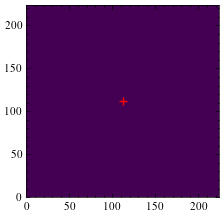

In [163]:
x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
						padding='SAME') )
	
im = plt.imshow(np.sum(x[0,:,:,:], axis=-1))
plt.plot(112, 112, marker = '+', color='red')
plt.xlim([0, 224])#, ylim=(0, 224))
plt.ylim([0, 224])#, ylim=(0, 224))

#, ylim=(0, 224))

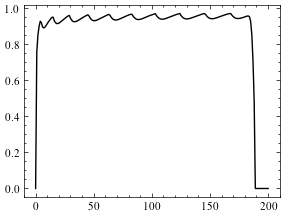

In [164]:
plt.plot(v)

In [165]:
pos[x.shape[1]//2]

array([0.])